In [51]:
import pandas as pd
import numpy as np
# data 시각화
import matplotlib
import matplotlib.pyplot as plt

# Korean pont
matplotlib.rc('font',family = 'NanumGothicCoding')

# train, test 데이터 분할 함수
from sklearn.model_selection  import train_test_split
# Grid Search
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.tree import export_graphviz
# import graphviz


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [52]:
df_raw = pd.read_csv("./data/Concrete.csv", encoding = '949')
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## Step01 - 목표변수(Y)제거 후 따로 저장, 설명변수와 목표변수 분리

In [54]:
df_raw_y = df_raw['CONCRETE_COMPRESSIVE_STRENGTH']
df_raw_x = df_raw.drop('CONCRETE_COMPRESSIVE_STRENGTH', axis = 1, inplace = False)

### 데이터 분할
> - at first Devide (train 0.7 test 0.3)
- and then, dived train data to (train 0.4, validation 0.3)
- only use validation data instead of test to check cost
- finally use test date at once.

In [55]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.6, random_state = 1234)
### 데이터 분할


print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (412, 8)
train data Y size : (412,)
test data X size : (618, 8)
test data Y size : (618,)


In [56]:
df_test_x, df_validation_x, df_test_y, df_validation_y = train_test_split(df_test_x, df_test_y, test_size = 0.5, random_state = 1234)
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))
print("validation data X size : {}".format(df_validation_x.shape))
print("validation data Y size : {}".format(df_validation_y.shape))

test data X size : (309, 8)
test data Y size : (309,)
validation data X size : (309, 8)
validation data Y size : (309,)


## Step02 - 모델 생성

In [57]:
gb_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set : {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
print("Score on validation set : {:.3f}".format(gb_uncustomized.score(df_validation_x, df_validation_y)))

Score on training set : 0.949
Score on validation set : 0.900


> test data의 설명력이 높은편 : `과대적합은 아닌 듯해 보임`

In [58]:
gb_uncustomized

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=1234, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

## Step02 - 트리 수 변경에 다른 모델 성능

In [59]:
train_score = []; validation_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,15)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators = v_n_estimators, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    validation_score.append(gb.score(df_validation_x, df_validation_y))

df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['validationScore'] = validation_score
df_score_n['gap'] = (np.array(train_score) - np.array(validation_score))

df_score_n.round(3)

,n_estimators,TrainScore,validationScore,gap
0,10,0.635,0.617,0.019
1,20,0.800,0.780,0.020
2,30,0.863,0.844,0.019
3,40,0.893,0.866,0.027
4,50,0.911,0.876,0.035
5,60,0.922,0.884,0.039
6,70,0.931,0.890,0.042
7,80,0.938,0.893,0.045
8,90,0.944,0.898,0.046
9,100,0.949,0.900,0.049


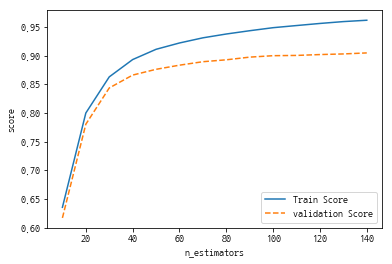

In [60]:
plt.plot(para_n_tree, train_score, linestyle = '-', label = "Train Score")
plt.plot(para_n_tree, validation_score, linestyle = '--', label = 'validation Score')
plt.ylabel('score'); plt.xlabel('n_estimators')
plt.legend()

## Step02 - Leaf Node 자료 수 지정

In [61]:
train_score = []; validation_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf :
    rf = GradientBoostingRegressor(random_state = 1234, n_estimators = 70,
                               min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_validation_x, df_validation_y))

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['validationScore'] = validation_score


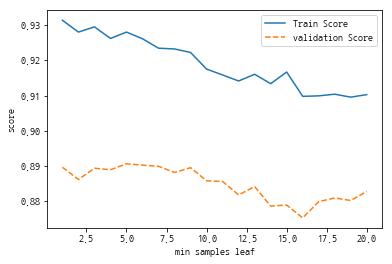

In [62]:
plt.plot(para_leaf, train_score, linestyle = '-', label = "Train Score")
plt.plot(para_leaf, validation_score, linestyle = '--', label = 'validation Score')
plt.ylabel('score'); plt.xlabel('min samples leaf')
plt.legend()

## Step02 - 분리노드(Splite)의 최소 자료 수 변경에 따른 모델 성능

In [63]:
train_score = []; validation_score = []

for v_min_samples_split in para_split :
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators = 70, min_samples_leaf = 6,
                                   min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    validation_score.append(gb.score(df_validation_x, df_validation_y))

df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['validationScore'] = validation_score

df_score_split.round(3)

,MinSamplesSplit,TrainScore,validationScore
0,2,0.926,0.890
1,4,0.926,0.890
2,6,0.926,0.890
3,8,0.926,0.890
4,10,0.926,0.890
5,12,0.926,0.890
6,14,0.924,0.892
7,16,0.923,0.889
8,18,0.924,0.889
9,20,0.922,0.890


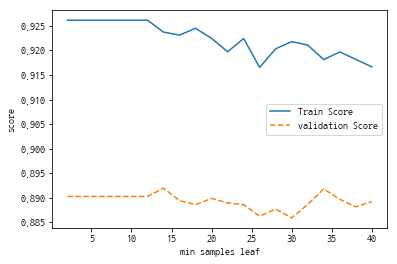

In [64]:
plt.plot(para_split, train_score, linestyle = '-', label = "Train Score")
plt.plot(para_split, validation_score, linestyle = '--', label = 'validation Score')
plt.ylabel('score'); plt.xlabel('min samples leaf')
plt.legend()

> min_split 는 28이 적당

In [65]:
train_score = []; validation_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth :
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators = 70, min_samples_leaf = 6,
                               min_samples_split = 28, max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    validation_score.append(gb.score(df_validation_x, df_validation_y))


df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['validationScore'] = validation_score

df_score_depth.round(3)

,Depth,TrainScore,validationScore
0,1,0.758,0.766
1,2,0.883,0.877
2,3,0.920,0.888
3,4,0.951,0.895
4,5,0.967,0.908
5,6,0.974,0.913
6,7,0.978,0.913
7,8,0.981,0.911
8,9,0.982,0.912
9,10,0.983,0.913


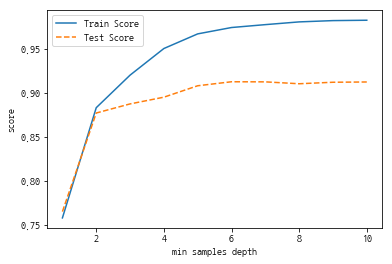

In [66]:
plt.plot(para_depth, train_score, linestyle = '-', label = "Train Score")
plt.plot(para_depth, validation_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('min samples depth')
plt.legend()

> depth = 5가 적당한듯 보여진다

## Learning Rate 을 0.1씩 증가

In [79]:
train_score = []; validation_score = []
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr :
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators = 70, min_samples_leaf = 6,
                               min_samples_split = 28, max_depth = 5, learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    validation_score.append(gb.score(df_validation_x, df_validation_y))

# 결과 저장
df_score_lr = pd.DataFrame()
df_score_lr['lr'] = para_lr
df_score_lr['TrainScore'] = train_score
df_score_lr['validationScore'] = validation_score

df_score_lr.round(3)

,lr,TrainScore,validationScore
0,0.1,0.967,0.908
1,0.2,0.978,0.908
2,0.3,0.985,0.904
3,0.4,0.987,0.897
4,0.5,0.989,0.905
5,0.6,0.989,0.889
6,0.7,0.991,0.864
7,0.8,0.991,0.841
8,0.9,0.992,0.869


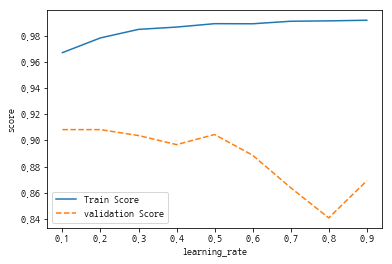

In [68]:
plt.plot(para_lr, train_score, linestyle = '-', label = "Train Score")
plt.plot(para_lr, validation_score, linestyle = '--', label = 'validation Score')
plt.ylabel('score'); plt.xlabel('learning_rate')
plt.legend()

> learning rate 는 `0.1` 이 적합하다

In [69]:
gb_final= GradientBoostingRegressor(random_state = 1234, n_estimators = 70, min_samples_leaf = 11,
                                    min_samples_split = 22, max_depth = 4, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

#train, test 데이터 설명력
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Score on validation set : {:.3f}".format(gb_final.score(df_validation_x, df_validation_y)))

gb_final

Score on training set : 0.948
Score on validation set : 0.896


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=11,
             min_samples_split=22, min_weight_fraction_leaf=0.0,
             n_estimators=70, n_iter_no_change=None, presort='auto',
             random_state=1234, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [70]:
v_feature_names = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_names
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)


,Feature,Importance
7,AGE,0.339
0,CEMENT,0.285
3,WATER,0.167
1,BLAST_FURNACE_SLAG,0.074
4,SUPERPLASTICIZER,0.070
6,FINE_AGGREGATE,0.042
5,COARSE_AGGREGATE,0.016
2,FLY_ASH,0.007


Text(0, 0.5, '변수')

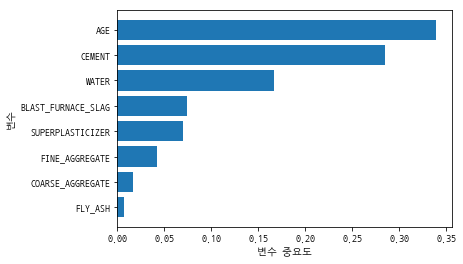

In [71]:
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

> 변수 중요도를 확인 할 수 있다. AGE, CEMENT, WATER가 중요한 설명변수이다.

In [73]:
estimator = GradientBoostingRegressor(random_state = 1234)

param_grid = {'criterion':['mse','friedman_mse','mae'],'max_features':['auto','sqrt','log2'], 'learning_rate':para_lr,
             'max_depth':para_depth,'min_samples_leaf':para_leaf}


grid_gb = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs=-1)
grid_gb.fit(df_train_x, df_train_y)

print("best estimator model : \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter : \n{}".format(grid_gb.best_params_))
print("\nbest score : \n{}".format(grid_gb.best_score_.round(3)))

best estimator model : 
GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=6,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=1234,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

best parameter : 
{'criterion': 'mse', 'learning_rate': 0.2, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 20}

best score : 
0.855


In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = gb_final.predict(df_test_x)

print('mse:{:.3f}'.format(mean_squared_error(df_test_y, y_pred)))
print('mae:{:.3f}'.format(mean_absolute_error(df_test_y, y_pred)))
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

mse:25.887
mae:3.912
Score on training set : 0.948
Score on test set : 0.905


> GridSearchCV 했을 때 `mse`, `best score=0.855` 로 확인됐다
하지만 직접 최적의 파리미터를 찾았을 땐 `mae`, `best score=0.905`으로 더 높게 나왔다